<a href="https://colab.research.google.com/github/bjohn22/Natural-Language-Processing/blob/main/Eluvio_NLP_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Natural Language Understanding: Semantic Analyses**
## Comparison of single predictors with Bidirectional Encoder Representations from Transformers (BERT)



Workflow:
* Single predictors
>Preprocess the dataset, split to train test, fit the model, evaluate

* BERT
>Preprocess the dataset using BERT custom preprocess steps, split the train test, fit and evaluate the model
>>save the model.


Connect to google drive: Directory for data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Dataset prepocessing



```
# This is formatted as code
```

1.Read in the dataset and snoop into the dataset

In [4]:
path = "/content/drive/MyDrive/Eluvio_DS_Challenge.csv"
news_df = pd.read_csv(path)

In [5]:
news_df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [6]:
len(news_df)

509236

In [7]:
print(sum(news_df['category'] == "worldnews"))
print(sum(news_df["down_votes"] == 0))

509236
509236


* It looks like the dataset contains headline news ('title' attribute) from around the world.
* The 'title' has a rating (i.e. 'up_votes', 'down_vote' attributes)
>The the 'up_vote' attribute will be used as label.

*Note*
* 'category' contains only "worldnews" and "down_votes" are only 0, so they are dropped.

In [8]:
news_df = news_df.drop("category", axis = 1)
news_df = news_df.drop("down_votes", axis = 1)
news_df = news_df.drop("time_created", axis = 1)
news_df = news_df.drop("date_created", axis = 1)

In [9]:
#Sanity check
news_df.head()

,up_votes,title,over_18,author
0,3,Scores killed in Pakistan clashes,False,polar
1,2,Japan resumes refuelling mission,False,polar
2,3,US presses Egypt on Gaza border,False,polar
3,1,Jump-start economy: Give health care to all,False,fadi420
4,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans


In [10]:
len(set(news_df['author']))  # the number of author

85838

# Process the 'title' (word vectorize)
In order for this text data to be usable by model we’ll need to convert each title to a numeric representation, which we call vectorization


In [20]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## build the corpus (normalize then tokenize)
### Normalization
Convert all the different forms of a given word into one using:
>>Stemming
>>Lemmatization

1. Stemming: SnowballStemmer wil be used for this case. But there are other algorithms in the NLTK package.

In [15]:
#convert all text to lowercase
title = news_df.title.str.lower()

In [16]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [17]:
# To get the stems of words in a sentence.
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# To get the words themselves in a sentence.
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [18]:
# Get full stems and tokens to build vocabulary
def tokenized_stemmed(title):
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in title:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)
    return totalvocab_stemmed, totalvocab_tokenized

In [21]:
totalvocab_stemmed_, totalvocab_tokenized_ = tokenized_stemmed(title)

In [23]:
print(len(totalvocab_stemmed_))

7194561


In [24]:
#Save the corpus in our directory for re-use
pickle.dump((totalvocab_stemmed_, totalvocab_tokenized_), open("/content/drive/MyDrive/stem_token_.pkl", "wb" ))

In [25]:
totalvocab_stemmed_, totalvocab_tokenized_ = pickle.load(open("/content/drive/MyDrive/stem_token_.pkl", "rb" ))

In [26]:
totalvocab = zip(totalvocab_stemmed_, totalvocab_tokenized_)

In [27]:
totalvocab = list(set(totalvocab))

In [28]:
totalvocab_stemmed, totalvocab_tokenized = zip(*totalvocab)

In [29]:
pickle.dump((totalvocab_stemmed, totalvocab_tokenized), open("/content/drive/MyDrive/stem_token.pkl", "wb" ))

In [30]:
totalvocab_stemmed, totalvocab_tokenized = pickle.load(open("/content/drive/MyDrive/stem_token.pkl", "rb" ))

In [31]:
print(len(totalvocab_stemmed))

115041


In [32]:
#stem-token vocabulary
vocab_frame = pd.DataFrame({'words_tokenized': totalvocab_tokenized}, index = totalvocab_stemmed)


In [33]:

pickle.dump(vocab_frame, open('/content/drive/MyDrive/vocab_frame.pkl','wb'))



In [34]:
#See the vocabulary we built
vocab_frame.head(30)

,words_tokenized
harder,harder
because….of,because….of
pavilion,pavilion
remote-control,remote-controlled
mujica,mujica
marietj,marietje
£130-an-hour,£130-an-hour
wreath,wreath
sou,sou
villag,villagers


In [35]:
vocab_frame = pickle.load(open('/content/drive/MyDrive/vocab_frame.pkl','rb'))

###Removing *stop words* such as ('but','we','he', 'if')
This is done without any noticeable effect on the semantics of the text.

In [36]:
# Build stopwords set. Combine two common set.
import sklearn.feature_extraction.text as text
stopwords = nltk.corpus.stopwords.words('english')
my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

Tf-idf to vectorize text.
TF-IDF stands for Term Frequency — Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.


In [37]:
# tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df =10**-3 ,analyzer = 'word', max_features=len(set(totalvocab_stemmed)), stop_words=my_stop_words, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(title)

print(tfidf_matrix.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', "n't", 'need', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sha', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'wo', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(509236, 1814)


In [39]:
#Getting the importance of words in the titles.
tf_idf = pd.DataFrame(tfidf_matrix[0].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["TF-IDF"])
tf_idf = tf_idf.sort_values('TF-IDF', ascending=False)
print (tf_idf.head(5))

            TF-IDF
score     0.656073
clash     0.513358
pakistan  0.441258
kill      0.333651
1st       0.000000


###Saving results

In [40]:
pickle.dump(tfidf_matrix, open("/content/drive/MyDrive/tfidf_matrix.pkl", "wb" ))


In [41]:
pickle.dump(tfidf_vectorizer, open( "/content/drive/MyDrive/tfidf_vectorizer.pkl", "wb" ))



In [42]:
tfidf_matrix = pickle.load(open("/content/drive/MyDrive/tfidf_matrix.pkl", "rb" ))


In [43]:
tfidf_vectorizer = pickle.load(open("/content/drive/MyDrive//tfidf_vectorizer.pkl", "rb" ))

In [44]:
tfidf_matrix

<509236x1814 sparse matrix of type '<class 'numpy.float64'>'
	with 3565328 stored elements in Compressed Sparse Row format>

Model

In [45]:
thre = np.quantile(news_df['up_votes'], 0.8)
y = [1 if i > thre else 0 for i in news_df['up_votes']]
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size = 0.2, shuffle = True, random_state = 123)

In [47]:
#Checking for imbalance in the label
np.unique(y, return_counts=True)

(array([0, 1]), array([409737,  99499]))

MultinomialNB

In [48]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [49]:
y_predict = clf.predict(X_test)
clf.score(X_test, y_test)

0.804335873065745

In [50]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     81923
           1       0.48      0.00      0.00     19925

    accuracy                           0.80    101848
   macro avg       0.64      0.50      0.45    101848
weighted avg       0.74      0.80      0.72    101848



LogisticRegression

In [51]:
LR = LogisticRegression(C=1.0, penalty='elasticnet', solver='saga', tol=0.01, l1_ratio=0.5)

In [52]:
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.01, verbose=0,
                   warm_start=False)

In [54]:
y_predict = LR.predict(X_test)
LR.score(X_test, y_test)

0.8050231717854057

In [55]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     81923
           1       0.52      0.04      0.07     19925

    accuracy                           0.81    101848
   macro avg       0.67      0.51      0.48    101848
weighted avg       0.75      0.81      0.73    101848




GBDT

In [56]:
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [57]:
y_predict = gbdt.predict(X_test)
gbdt.score(X_test, y_test)

0.8045715183410572

In [58]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     81923
           1       0.62      0.00      0.01     19925

    accuracy                           0.80    101848
   macro avg       0.71      0.50      0.45    101848
weighted avg       0.77      0.80      0.72    101848



Random Forest

In [59]:
rfc = RandomForestClassifier(n_jobs = -1, max_features = 'sqrt', n_estimators = 10, oob_score = True)
rfc.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [60]:
y_predict = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.791915403346163

In [61]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88     81923
           1       0.30      0.05      0.08     19925

    accuracy                           0.79    101848
   macro avg       0.55      0.51      0.48    101848
weighted avg       0.71      0.79      0.73    101848



XGB

In [62]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [63]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [64]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [65]:
y_predict = xgb.predict(X_test)

In [66]:
xgb.score(X_test, y_test)

0.8051311758699238

In [67]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     81923
           1       0.53      0.04      0.07     19925

    accuracy                           0.81    101848
   macro avg       0.67      0.51      0.48    101848
weighted avg       0.75      0.81      0.73    101848



## BERT

In [ ]:
title_vote= news_df[['title', 'up_votes']].copy()
title_vote.head()


,title,up_votes
0,Scores killed in Pakistan clashes,3
1,Japan resumes refuelling mission,2
2,US presses Egypt on Gaza border,3
3,Jump-start economy: Give health care to all,1
4,Council of Europe bashes EU&UN terror blacklist,4


In [ ]:
thre = np.quantile(news_df['up_votes'], 0.8)
title_vote['y_vote'] = [1 if i > thre else 0 for i in news_df['up_votes']]

In [ ]:
title_vote.head()
title_vote.describe()

,up_votes,y_vote
count,509236.000000,509236.000000
mean,112.236283,0.195389
std,541.694675,0.396500
min,0.000000,0.000000
25%,1.000000,0.000000
50%,5.000000,0.000000
75%,16.000000,0.000000
max,21253.000000,1.000000


In [ ]:
np.histogram(news_df['up_votes'])

(array([501276,   5438,   1985,    493,     37,      4,      2,      0,
             0,      1]),
 array([    0. ,  2125.3,  4250.6,  6375.9,  8501.2, 10626.5, 12751.8,
        14877.1, 17002.4, 19127.7, 21253. ]))

In [ ]:
import matplotlib.pyplot as plt

(array([5.01276e+05, 5.43800e+03, 1.98500e+03, 4.93000e+02, 3.70000e+01,
        4.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([    0. ,  2125.3,  4250.6,  6375.9,  8501.2, 10626.5, 12751.8,
        14877.1, 17002.4, 19127.7, 21253. ]),
 <a list of 10 Patch objects>)

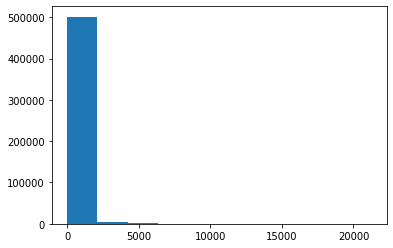

In [ ]:
plt.hist(news_df['up_votes'])



{'boxes': [<matplotlib.lines.Line2D at 0x7f1b571b8350>],
 'caps': [<matplotlib.lines.Line2D at 0x7f1b571ce390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1b571df3d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1b571cee50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1b571b88d0>,
  <matplotlib.lines.Line2D at 0x7f1b571b8e10>]}

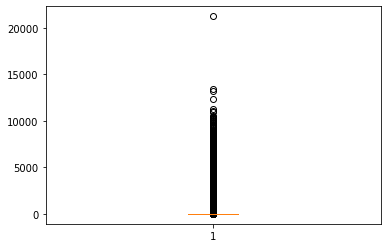

In [ ]:
plt.boxplot(news_df['up_votes'])

In [ ]:
news_df.describe()

,up_votes
count,509236.000000
mean,112.236283
std,541.694675
min,0.000000
25%,1.000000
50%,5.000000
75%,16.000000
max,21253.000000


In [ ]:
#BERT

In [ ]:
path = "/content/drive/MyDrive/Eluvio_DS_Challenge.csv"
news_df = pd.read_csv(path)

FileNotFoundError: ignored

In [ ]:
!pip install -q -U tensorflow-text
!pip install transformers

     |████████████████████████████████| 3.4MB 10.9MB/s 
     |████████████████████████████████| 2.1MB 11.3MB/s 
     |████████████████████████████████| 870kB 42.6MB/s 
     |████████████████████████████████| 3.3MB 44.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=257346f413469e089b2c0bc486ec86907c62228430df1be0797119c1130fc5e8
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
pip install tf-models-official

     |████████████████████████████████| 1.1MB 11.0MB/s 
     |████████████████████████████████| 37.6MB 123kB/s 
     |████████████████████████████████| 174kB 48.2MB/s 
     |████████████████████████████████| 706kB 33.5MB/s 
     |████████████████████████████████| 358kB 43.6MB/s 
     |████████████████████████████████| 645kB 45.1MB/s 
     |████████████████████████████████| 1.2MB 40.6MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22245 sha256=c52f2bbaa54724874a79792a892852b1e393467d95167f9aa2d24573061b4f96
  Stored in directory: /root/.cache/pip/wheels/2e/15/f5/aa2a056d223903b52cf4870134e3a01df0c723816835dd08db
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=2179f08aec1e560c6e30232dad992b14e9fd135f3b03865b9f87099946532732
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214

In [ ]:
import tensorflow as tf
import os
import shutil
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
#From Hugging Face Transfromers library

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
import pandas as pd

In [ ]:
title_vote.head()
title_vote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   title     509236 non-null  object
 1   up_votes  509236 non-null  int64 
 2   y_vote    509236 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 11.7+ MB


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
#Stratified splitting (35% test) the dataset to maintain data distribtion
split = StratifiedShuffleSplit(n_splits=1, test_size=0.35, random_state=42)
for train_index, test_index in split.split(title_vote, title_vote["y_vote"]):
    strat_train_news = title_vote.loc[train_index]
    strat_test_news = title_vote.loc[test_index]

In [ ]:
strat_train_news.info()
strat_train_news.head()
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331003 entries, 149289 to 393311
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   title     331003 non-null  object
 1   up_votes  331003 non-null  int64 
 2   y_vote    331003 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 10.1+ MB


,title,up_votes,y_vote
149289,The Saudi government is placing its bets squar...,48,1
491574,The long-lost ship of British polar explorer S...,1737,1
385457,US Embassy employee gunned down in Pakistan,51,1
172973,Malawi: Madonna Demanded Special Treatment,4,0
308167,Gay sex could be punishable by 100 lashes of t...,508,1


In [ ]:
strat_test_news.info()
strat_test_news.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178233 entries, 497236 to 68455
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   title     178233 non-null  object
 1   up_votes  178233 non-null  int64 
 2   y_vote    178233 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.4+ MB


,title,up_votes,y_vote
497236,Bomb Threat Prompts Evacuation at Brussels Tra...,15,0
107103,India’s ‘Hitler’ Soap Opera Stirs Controversy,4,0
125184,"Euro Crisis Deepens: After Spain, the focus of...",2,0
395063,Australia s Bernie Fraser quits as chairman of...,8,0
265185,UK: Illegal immigrants and foreign offenders ...,6,0


In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )




In [ ]:
DATA_COLUMN = 'title' 
LABEL_COLUMN = 'y_vote' 

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(strat_train_news, strat_test_news, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)


Epoch 1/2
20688/20688 [==============================] - 10848s 523ms/step - loss: 0.4513 - accuracy: 0.8073 - val_loss: 0.4794 - val_accuracy: 0.7906
Epoch 2/2
20688/20688 [==============================] - 10847s 524ms/step - loss: 0.3041 - accuracy: 0.8661 - val_loss: 0.7437 - val_accuracy: 0.7668


In [34]:
from tensorflow import keras

In [35]:
model.save('/content/drive/MyDrive')

In [ ]:
#"/content/drive/MyDrive

Making predictions

In [68]:
#Create a set from the original dataset
pred_sentences = ['The police officer who leaked the footage of sex is killed',
                  'DOW is up 5% today', 'It s election year']

In [70]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
#labels = ['Negative','Positive']
labels = [0,1]
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

The police officer who leaked the footage of sex is killed : 
 1
DOW is up 5% today : 
 0
It s election year : 
 0


In [71]:
strat_test_news.sort_values(by=['up_votes'], ascending=False)

,title,up_votes,y_vote
391415,Twitter has forced 30 websites that archive po...,13435,1
391318,The police officer who leaked the footage of t...,12333,1
390252,Paris shooting survivor suing French media for...,11288,1
449809,Hundreds of thousands of leaked emails reveal ...,11108,1
500786,Feeding cows seaweed could slash global greenh...,10394,1
...,...,...,...
137417,PLO: 18 Palestinians killed in Damascus by Syr...,0,0
398787,Silicon Valley shouldn’t let China strong-arm ...,0,0
468658,Facebook accidentally declared the Philippines...,0,0
2576,Jewish groups condemn FIA boss over Nazi sex...,0,0
